In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcard.csv


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score
)

Download Dataset using kagglehub

In [3]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("✅ Download complete. Path to dataset files:", path)


✅ Download complete. Path to dataset files: /kaggle/input/


Load & Explore Dataset

In [4]:
df = pd.read_csv(path + "/creditcard.csv")
print("✅ Dataset loaded successfully.\n")
print(df.head())

print("\n🔢 Class distribution:")
print(df['Class'].value_counts())

✅ Dataset loaded successfully.

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   



Data Preprocessing

In [5]:
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

print("\n✅ Data preprocessing completed.")


✅ Data preprocessing completed.


Train Random Forest Model

In [6]:
rfc = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handles class imbalance
)
rfc.fit(X_train, y_train)

print("\n✅ Model training completed.")


✅ Model training completed.


Evaluation & Metrics

In [7]:
y_pred = rfc.predict(X_test)
y_probs = rfc.predict_proba(X_test)[:, 1]

print("\n📉 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print(f"✅ Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ ROC AUC Score: {roc_auc_score(y_test, y_probs):.4f}")



📉 Confusion Matrix:
 [[85292     3]
 [   44   104]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.97      0.70      0.82       148

    accuracy                           1.00     85443
   macro avg       0.99      0.85      0.91     85443
weighted avg       1.00      1.00      1.00     85443

✅ Accuracy Score: 0.9994
✅ ROC AUC Score: 0.9376


Feature Importance Visualization

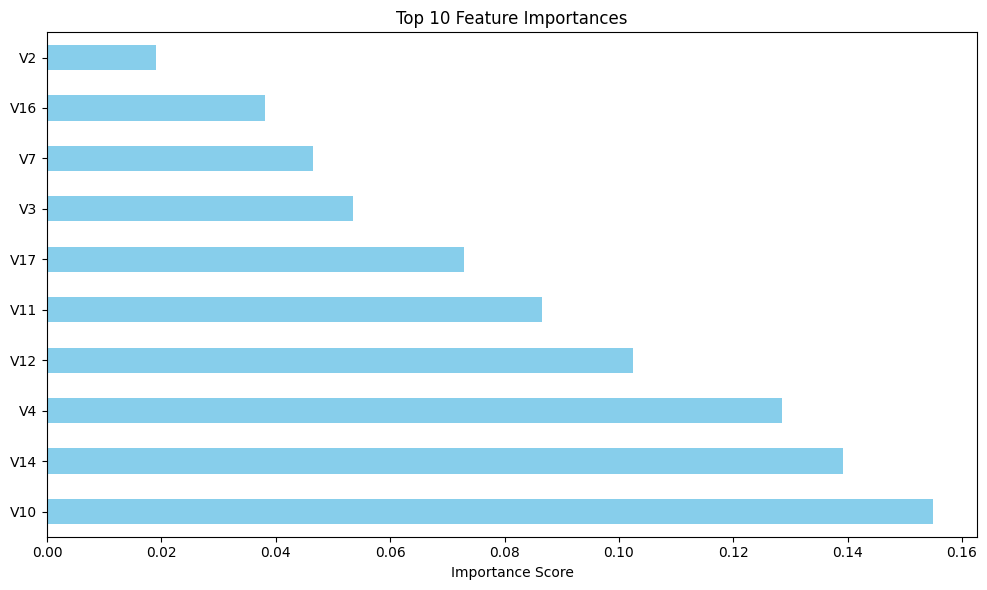

In [8]:
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh', color='skyblue')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

**Class Imbalance Bar Plot**

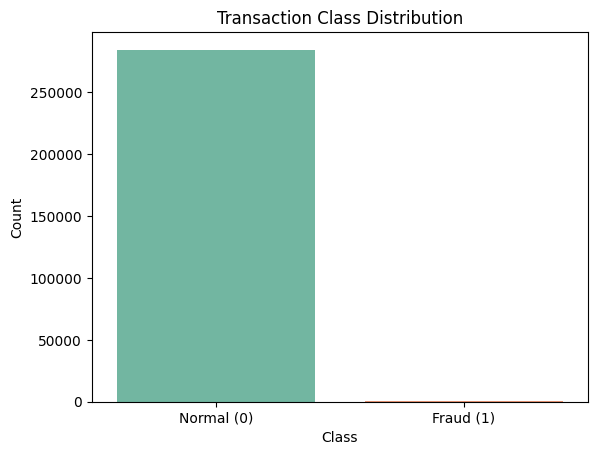

In [9]:
# Plot class distribution
sns.countplot(data=df, x='Class', palette='Set2')
plt.title("Transaction Class Distribution")
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.ylabel("Count")
plt.show()


**Amount Distribution (Fraud vs Normal)**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


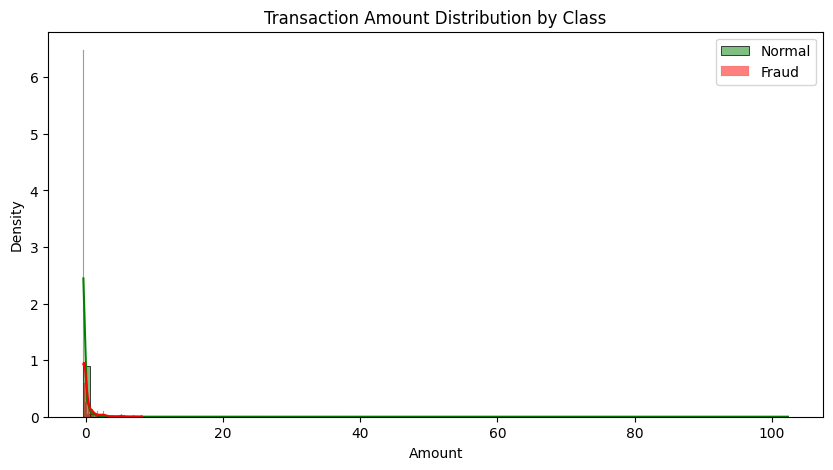

In [10]:
# Plot amount distribution for each class
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=100, color='green', label='Normal', stat='density', kde=True)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=100, color='red', label='Fraud', stat='density', kde=True)
plt.legend()
plt.title("Transaction Amount Distribution by Class")
plt.xlabel("Amount")
plt.show()


**Correlation Heatmap of Top Features**

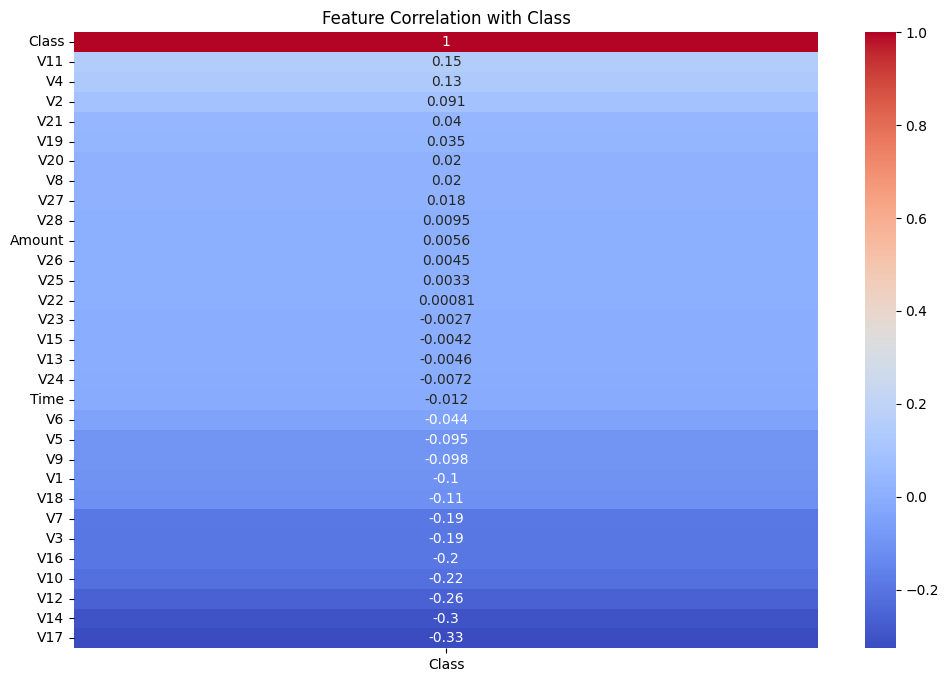

In [11]:
# Compute correlation and plot heatmap
corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Class")
plt.show()


**Full Correlation Matrix**

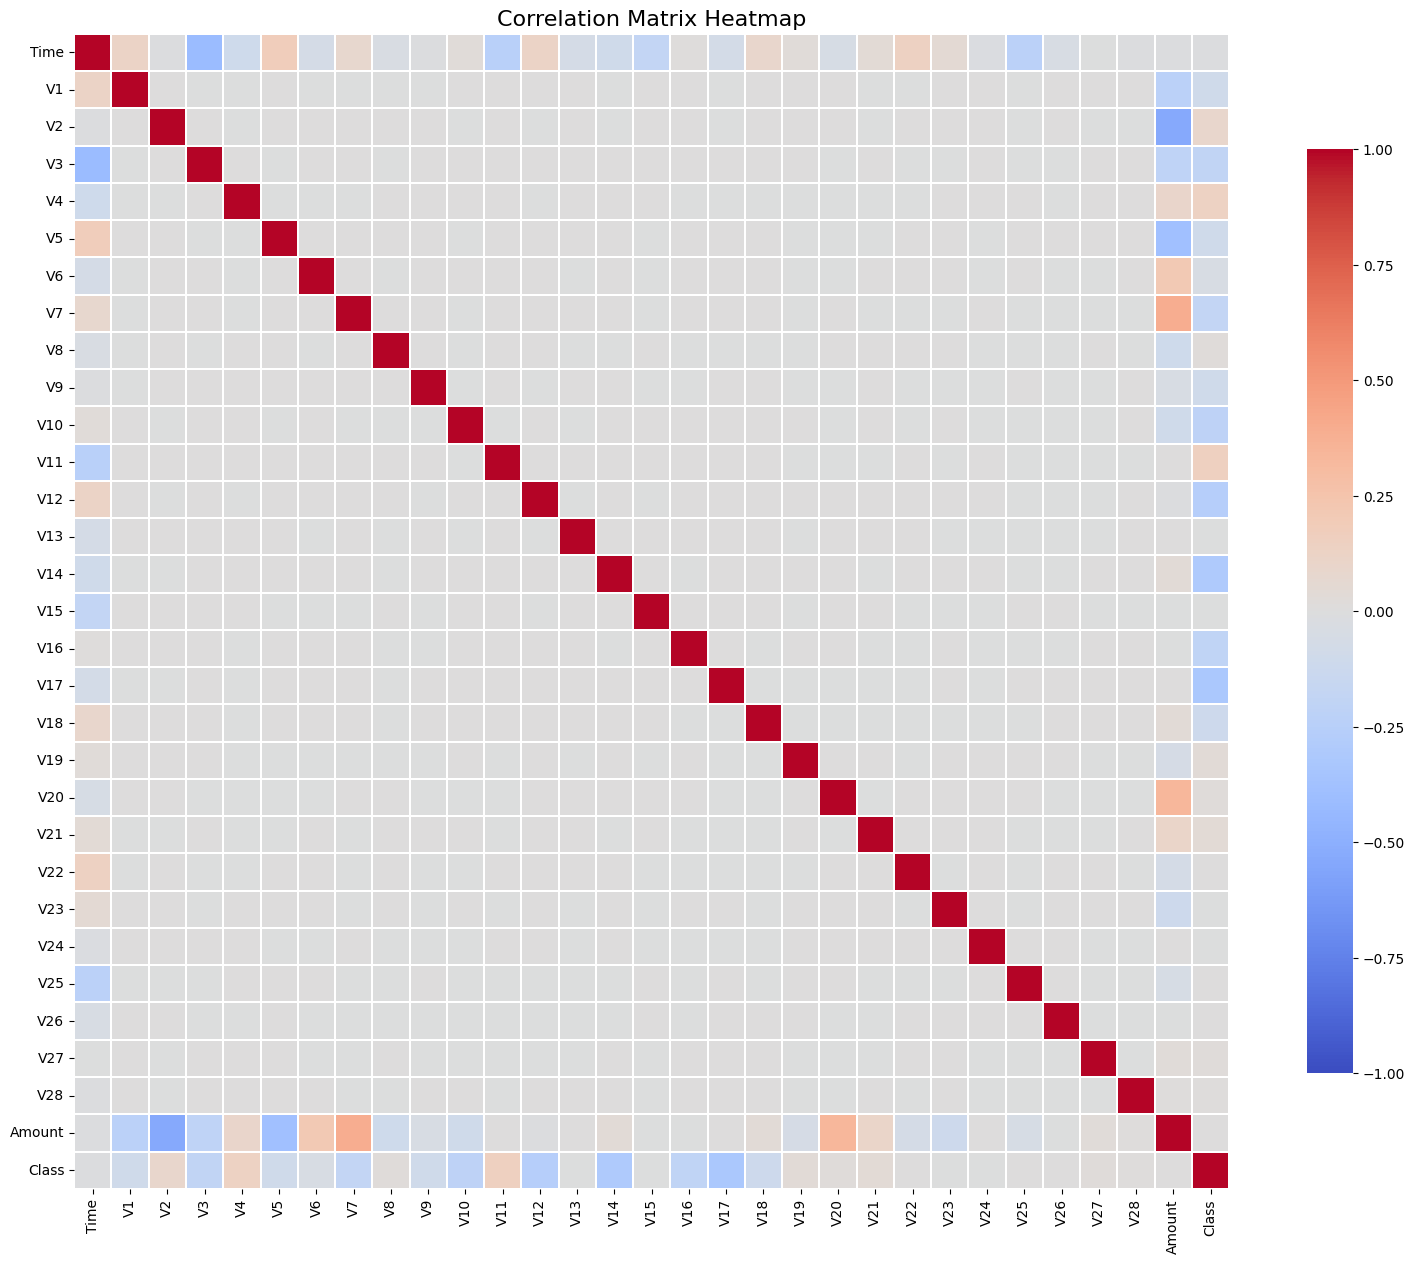

In [12]:
#  Full Correlation Matrix
plt.figure(figsize=(20, 15))
corr_matrix = df.corr()

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    annot=False,
    fmt=".2f",
    linewidths=0.2,
    square=True,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()


In [13]:
#  Top correlations with Class
top_corr = corr_matrix['Class'].abs().sort_values(ascending=False)[1:11]  # top 10 excluding 'Class' itself
print("Top correlated features with 'Class':\n", top_corr)


Top correlated features with 'Class':
 V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
Name: Class, dtype: float64


**PCA 2D Scatter Plot (visualize separation)**

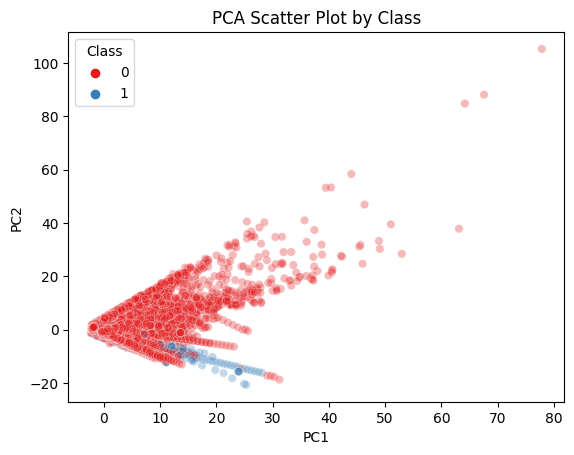

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(df.drop(['Class', 'Time'], axis=1))
df_pca = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
df_pca['Class'] = df['Class']

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Class', palette='Set1', alpha=0.3)
plt.title("PCA Scatter Plot by Class")
plt.show()


**Boxplot of Selected Feature**

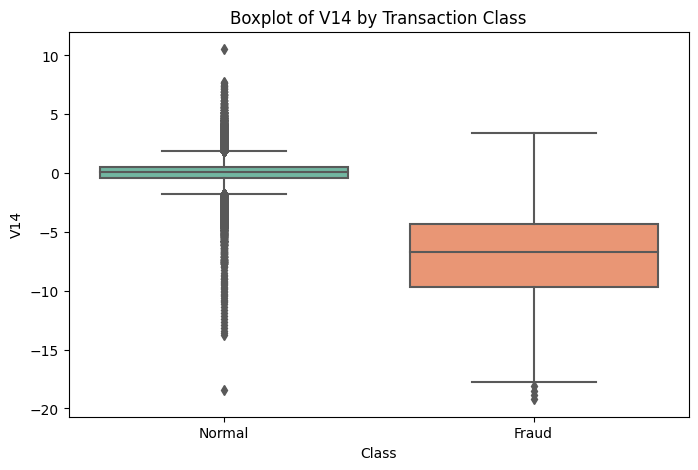

In [15]:
# Boxplot of V14 feature
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Class', y='V14', palette='Set2')
plt.title("Boxplot of V14 by Transaction Class")
plt.xticks([0, 1], ['Normal', 'Fraud'])
plt.show()


**Fraud vs. Time Distribution**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


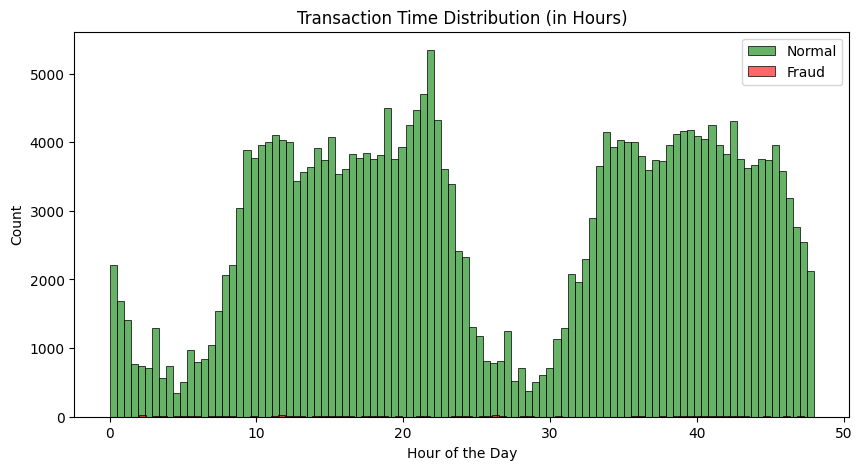

In [16]:
# Time is in seconds since first transaction. Normalize to hours.
df['Hour'] = df['Time'] / 3600

plt.figure(figsize=(10, 5))
sns.histplot(data=df[df['Class'] == 0], x='Hour', bins=100, color='green', label='Normal', alpha=0.6)
sns.histplot(data=df[df['Class'] == 1], x='Hour', bins=100, color='red', label='Fraud', alpha=0.6)
plt.legend()
plt.title("Transaction Time Distribution (in Hours)")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.show()
